<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Conv_Regression_ResNet_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb  8 10:47:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install yfinance

In [4]:
import matplotlib
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pickle import dump

from IPython import display

import tensorflow as tf

from sklearn import metrics
from scipy import stats

tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

# Get data

In [ ]:
folder = '/content/drive/MyDrive/Trading/1_days/'

In [6]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2018,2,1)
end = dt.datetime(2022,1,31)

df = yf.download('BTC-USD', start, end).drop('Adj Close', axis=1)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,9959400448
2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,12726899712
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,7263790080
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7073549824
2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,9285289984
...,...,...,...,...,...
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075


# Indicators

https://www.ig.com/es/estrategias-de-trading/los-10-mejores-indicadores-de-trading-para-inversores-190830

In [7]:
# Fear index
df_fear = pd.read_csv('/content/drive/MyDrive/Trading/fear_index.csv')
df_fear = df_fear[df_fear.date.between('2018-02-01', '2022-01-31')]
df_fear['date'] = pd.to_datetime(df_fear['date'])
df['date'] = pd.to_datetime(df.index)
df = df.join(df_fear.set_index('date'), on='date')
df = df.drop(['date'], axis=1)
df['value'] = df['value'].fillna(25) # Fill 3 consequtive days taking sorrounding values (23-26)

In [8]:
price = 'Close'

# MovingAverage
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
values_ma = range(2,30,2)
for i in values_ma:
    df["maclose" + str(i)] = df[price].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = range(2,30,2)
for i in values_ema:
    df["ema" + str(i)] = df[price].ewm(span = i, adjust = False).mean()

# Wight Moving Average
# https://predictivehacks.com/?all-tips=how-to-apply-a-rolling-weighted-moving-average-in-pandas
weights = np.array([0.1, 0.2, 0.3, 0.4]) #Tienen que sumar 1 🙂
df['wma'] = df[price].rolling(4).apply(lambda x: np.sum(weights*x))

# RSI
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = range(2,30,2)
close = df[price]

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    roll_up1 = up.ewm(span=i).mean()
    roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    df["rsiewma" + str(i)] = RSI1.values
    df["rsisma" + str(i)]  = RSI2.values

# BollingerBand
values_bollinger = range(2,30,2)
for i in values_bollinger:
    df['bollingerupper' + str(i)] = df[price].rolling(window=i).mean() + (df[price].rolling(window=i).std() * 2)
    df['bollingerlower' + str(i)] = df[price].rolling(window=i).mean() - (df[price].rolling(window=i).std() * 2)

In [9]:
df = df.dropna()
df.tail(5)

,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629,20.0,36995.177734,36899.671875,36484.290365,37005.434570,38016.343750,38793.988932,39414.640346,39896.602295,40161.264106,40327.414844,40512.142223,40863.904460,41328.347806,41733.225028,37037.379432,37003.899549,37254.861371,37639.899709,38060.480683,38480.322624,38887.721390,39279.731716,39656.626900,40019.796764,40370.846062,40711.196995,41041.941079,41363.820160,36967.163672,88.297985,73.741279,60.598852,90.435293,45.956740,59.106063,39.329044,24.483816,35.917191,23.869331,33.996246,21.803489,32.868982,25.859280,32.209263,29.814816,31.844184,33.950322,31.673026,35.484824,31.633276,31.344301,31.684540,26.844454,31.800009,25.299785,31.961532,28.733783,37399.803017,36590.552452,37303.517833,36495.825917,38025.658472,34942.922257,40248.471397,33762.397744,43157.982976,32874.704524,44706.644414,32881.333450,45702.580361,33126.700331,46334.754032,33458.450557,46409.870322,33912.657890,46326.124569,34328.705119,46362.964478,34661.319968,46980.115799,34747.693120,48054.898059,34601.797554,48865.957107,34600.492949
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523,24.0,37461.283203,37182.172852,36943.304036,36643.423828,37557.213672,38349.860026,39034.971261,39511.304199,39936.990234,40129.934375,40267.751420,40525.852702,40960.621394,41428.863839,37535.347831,37316.072542,37406.138702,37671.995780,38010.271837,38373.247148,38740.602809,39103.802342,39459.543230,39806.895361,40145.931798,40477.047797,40800.636705,41116.958910,37321.027734,98.018923,100.000000,80.489905,92.361288,62.676847,96.555508,52.409849,33.177970,46.478115,27.719120,42.808736,26.400476,40.409137,26.753990,38.781145,26.821595,37.652369,36.915482,36.862002,37.417105,36.309357,34.614930,35.928602,29.927724,35.675263,27.927296,35.518470,31.774526,38375.003271,36547.563135,38019.248314,36345.097389,37955.819005,35930.789068,38239.493610,35047.354046,41689.710650,33424.716694,43611.369062,33088.350990,44997.915346,33072.027176,45645.370890,33377.237509,46222.930187,33651.050281,46193.378676,34066.490074,46104.082916,34431.419925,46371.690700,34680.014704,47356.019874,34565.222915,48478.925181,34378.802497
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075,24.0,37961.255859,37478.216797,37253.533203,36853.531738,37196.598828,38007.162435,38675.027065,39232.967285,39681.563802,39941.263281,40112.309482,40299.568359,40640.623798,41087.841239,37937.235735,37644.915400,37615.293270,37775.592204,38033.527810,38337.082923,38660.279726,38990.199676,39320.452331,39647.970059,39971.344658,40289.938349,40603.417667,40911.525860,37703.430469,99.162285,100.000000,86.644272,92.659430,69.832950,95.066544,58.682490,67.735259,51.795701,32.015610,47.357905,30.929744,44.358457,28.481444,42.255739,31.889182,40.743358,34.535869,39.636887,38.111872,38.819380,39.461074,38.213601,35.109074,37.766867,30.307338,37.

# Create sequences

In [10]:
#columns = ["prices", "total_volumes", "market_caps", "ema_5", "ema_10", "ema_15", "ema_30"]
columns = df.columns

df_rs = np.array(df[columns])
df_rs.shape

(1433, 91)

In [11]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix][:,df.columns.get_loc(price)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
past_t = 7
forecast_t = 1
n_steps_in = past_t
n_steps_out = forecast_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

print("Example of day -->")
pd.DataFrame(X[-1], columns=columns)

Shape X --> (1426, 7, 91)
Shape y --> (1426, 1)
Example of day -->


,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,36275.734375,37247.519531,33184.058594,36654.328125,4.185666e+10,13.0,36465.566406,36104.674805,37807.240885,38933.703613,39776.090625,40287.681315,40724.080915,40866.874756,40953.435547,41194.588672,41647.612038,42136.645671,42490.925631,42814.201172,36500.291531,36957.037842,37692.174476,38362.196147,38940.711194,39448.512403,39904.903812,40323.418945,40713.436639,41081.590853,41432.593850,41769.736556,42095.239179,42410.523820,36196.554297,70.550130,100.000000,40.935018,22.326412,32.435652,18.106753,29.133020,17.565604,27.701234,18.089347,27.102486,19.515563,26.932901,31.667906,27.006735,32.314051,27.225842,29.842812,27.533009,25.516267,27.892973,23.698781,28.283470,28.109049,28.690365,29.302391,29.104726,24.887354,36999.465172,35931.667641,37570.049491,34639.300118,43244.977161,32369.504610,45140.754036,32726.653191,46301.587069,33250.594181,46659.275469,33916.087161,47008.999703,34439.162128,46769.720019,34964.029493,46521.366561,35385.504532,46668.142674,35721.034670,47625.615534,35669.608542,48741.146527,35532.144815,49306.814160,35675.037102,49796.158995,35832.243349
1,36654.804688,37444.570312,35779.429688,36954.003906,2.642819e+10,12.0,36804.166016,36228.846680,37008.853516,38271.635254,39153.751172,39817.884115,40311.091518,40557.024902,40697.663411,40863.838672,41215.606889,41689.445312,42097.690204,42434.385045,36802.766448,36955.824268,37481.268599,38049.264538,38579.491687,39064.741865,39511.450491,39927.017175,40317.706877,40688.487335,41043.151246,41384.477944,41714.406937,42034.212101,36536.285937,83.635317,100.000000,49.922971,57.411431,38.657795,22.271259,33.968485,21.809540,31.693987,19.851010,30.515237,24.155951,29.913798,28.550258,29.649104,32.884303,29.593432,34.484349,29.672050,30.367898,29.838515,25.922520,30.062974,24.403295,30.325891,27.981639,30.614333,28.810664,37227.971570,36380.360461,37920.323918,34537.369442,40841.768105,33175.938927,43970.464249,32572.806259,45419.423018,32888.079326,46278.937246,33356.830983,46783.614838,33838.568197,46739.719601,34374.330204,46563.023568,34832.303255,46529.354283,35198.323061,47109.912973,35321.300806,48177.795266,35201.095359,48968.140326,35227.240083,49495.520320,35373.249770
2,36950.515625,38825.410156,36374.906250,36852.121094,3.132460e+10,23.0,36903.062500,36684.314453,36370.804036,37581.196289,38527.575391,39297.252604,39804.164342,40246.453613,40426.451172,40548.398242,40804.449929,41252.232910,41734.062350,42091.792550,36835.669545,36914.342998,37301.512169,37783.232661,38265.424306,38724.338669,39156.873238,39565.264695,39952.908374,40323.119121,40678.713841,41021.889396,41354.237615,41676.826515,36785.595703,57.553460,74.628158,45.960102,94.970331,37.034469,25.062570,32.984699,20.528758,30.982996,19.777497,29.951839,20.251465,29.442605,21.305178,29.241242,32.858115,29.232069,33.465075,29.346550,30.930032,29.541720,26.539270,29.789819,24.685543,30.072639,28.941221,30.378127,30.059107,37047.146555,36758.978445,37281.926210,36086.702697,37775.248268,34966.359805,42252.856602,32909.535976

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

test_size = 200
train_size = len(X) - test_size
X_train = X[0:train_size]
y_train = y[0:train_size]
X_test = X[train_size:len(X)]
y_test = y[train_size:len(X)]

scaler = MinMaxScaler(feature_range=(-1,1)) #Try this
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_new = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
# save the scaler
dump(scaler, open(folder + 'scaler.pkl', 'wb'))

print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))
print("Example of day -->")
pd.DataFrame(X_train[-1], columns=columns)

Shape X_train --> (1226, 7, 91)
Shape y_train --> (1226, 1)
Shape X_test  --> (200, 7, 91)
Shape y_test  --> (200, 1)
Example of day -->


,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,0.016905,-0.005239,-0.019213,-0.016352,-0.844924,-0.666667,0.003105,0.020474,0.049148,0.054180,0.075663,0.088496,0.079183,0.083122,0.077153,0.086291,0.101869,0.122388,0.141588,0.153923,0.001294,0.025054,0.042405,0.054015,0.063037,0.071285,0.079284,0.087491,0.096033,0.105022,0.114539,0.124635,0.135329,0.146617,0.014369,-0.893349,-1.000000,-0.641200,-0.711289,-0.481189,-0.213342,-0.382190,-0.360492,-0.320818,-0.183151,-0.278143,0.061530,-0.243503,-0.132883,-0.218733,-0.010495,-0.202610,-0.184966,-0.194984,-0.194712,-0.191092,-0.313549,-0.190090,-0.385284,-0.191371,-0.149059,-0.194481,-0.196995,-0.008696,-0.020427,-0.002789,0.016712,0.016832,0.053767,0.008665,0.070826,0.022854,0.094641,0.017554,0.109432,0.028463,0.069103,0.026252,0.086700,0.034070,0.077530,0.052183,0.080154,0.080408,0.084240,0.123721,0.069099,0.160440,0.070398,0.162179,0.098347
1,-0.017196,-0.000875,-0.012920,0.014200,-0.859142,-0.666667,0.002151,0.020910,0.044203,0.055152,0.068459,0.085998,0.084637,0.083288,0.081343,0.083051,0.094931,0.112462,0.134204,0.149312,0.013648,0.027422,0.042250,0.053014,0.061642,0.069625,0.077399,0.085392,0.093719,0.102486,0.111773,0.121632,0.132085,0.143130,0.015971,0.417234,-0.030189,0.081827,0.018791,-0.012483,-0.176627,-0.046709,0.014785,-0.063078,-0.258313,-0.070212,-0.097084,-0.070039,0.180575,-0.069937,-0.030174,-0.072499,0.103469,-0.079753,-0.129379,-0.087608,-0.245249,-0.096080,-0.342292,-0.105142,-0.274685,-0.114741,-0.184979,-0.012149,-0.018699,-0.002211,0.016979,0.009617,0.051576,0.008575,0.072966,0.005157,0.100189,0.015826,0.106192,0.019979,0.090668,0.026325,0.086966,0.030088,0.091227,0.045568,0.081100,0.057884,0.096318,0.090025,0.088580,0.145317,0.072884,0.156461,0.095388
2,0.014306,0.004541,0.014093,0.004991,-0.884795,-0.666667,0.012858,0.014916,0.034165,0.053532,0.063168,0.083318,0.088005,0.080755,0.083348,0.079168,0.091235,0.105213,0.124872,0.146663,0.011590,0.025093,0.039428,0.050109,0.058748,0.066727,0.074466,0.082389,0.090613,0.099250,0.108384,0.118071,0.128339,0.139190,0.013680,-0.128484,0.536792,-0.115424,-0.279612,-0.131223,-0.385282,-0.131681,-0.088067,-0.129084,-0.203241,-0.123930,-0.103266,-0.115071,0.112941,-0.108627,-0.115804,-0.106299,0.035196,-0.109603,-0.148144,-0.114302,-0.154449,-0.120204,-0.275227,-0.127141,-0.345208,-0.134960,-0.132148,-0.030652,0.021905,-0.015988,0.019655,-0.020705,0.064866,0.008561,0.069587,-0.003575,0.099230,0.015029,0.101458,0.013085,0.105950,0.023636,0.084806,0.028551,0.097341,0.037385,0.082541,0.051030,0.096594,0.069829,0.097459,0.119981,0.083600,0.155090,0.091327
3,0.004282,0.016739,0.021912,0.028874,-0.901248,-0.666667,0.020219,0.018144,0.036972,0.051690,0.065493,0.078544,0.086971,0.086528,0.084370,0.083738,0.088993,0.099485,0.116281,0.140329,0.026922,0.033422,0.044443,0.053367,0.060926,0.068147,0.075296,0.082727,0.090521,0.098764,0.107529,0.116865,0.126795,0.137321,0.023428,0.717560,0.443435,0.375796,0.132905,0.210246,0.131264,0.123591,-0.097584,0.072157,0.098239,0.040909,-0.194408,0.023693,-0.043720,0.011046,0.17

# Model 

Transfer learning work-flow

https://keras.io/guides/transfer_learning/ (The typical transfer-learning workflow)

In [15]:
from tensorflow.keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations

Gan inspiration

https://keras.io/examples/generative/conditional_gan/

In [17]:
# Get square shape
image_shape = X_train.shape[1]

if X_train.shape[1]<X_train.shape[2]:
  image_shape = X_train.shape[2]

# Load Resnet model
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(image_shape, image_shape, 3),
    include_top=False) 
base_model.trainable = False

# Create input as image
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
if X_train.shape[1]<X_train.shape[2]:
  input_img = layers.Reshape((X_train.shape[2], X_train.shape[1]))(inputs) 
  input_img = layers.Dense(image_shape, activation='tanh')(input_img) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
else:
  input_img = layers.Dense(image_shape, activation='tanh')(inputs) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
# With tahn all outputs are between -1 and 1 (ResNet needs that)

# Create Model
x = base_model(input_img, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x) 

# Output layer
predictions = layers.Dense(y_train.shape[1], activation="relu")(x) #Relu for getting positive values
model = tf.keras.Model(inputs, predictions)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 91)]           0         
                                                                 
 reshape (Reshape)           (None, 91, 7)             0         
                                                                 
 dense (Dense)               (None, 91, 91)            728       
                                                                 
 reshape_1 (Reshape)         (None, 91, 91, 1)         0         
                                                                 
 image_inp (Dense)           (None, 91, 91, 3)         6         
                                                                 
 resnet152v2 (Functional)    (None, 3, 3, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [18]:
#tf.keras.utils.plot_model(model, to_file="model.png")

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=7, verbose=1, factor=0.5, min_lr=5e-5)

In [20]:
history = model.fit(X_train, y_train, epochs = 700, batch_size = 16, 
                    callbacks=[learning_rate_reduction, early_stopping],
                    validation_data= (X_test, y_test))

Epoch 1/700
77/77 [==============================] - 24s 167ms/step - loss: 13781.6641 - mae: 13781.6641 - val_loss: 48033.0312 - val_mae: 48033.0312 - lr: 0.0100
Epoch 2/700
77/77 [==============================] - 13s 163ms/step - loss: 11338.5986 - mae: 11338.5986 - val_loss: 45816.6719 - val_mae: 45816.6719 - lr: 0.0100
Epoch 3/700
77/77 [==============================] - 9s 117ms/step - loss: 9183.5068 - mae: 9183.5068 - val_loss: 44209.0781 - val_mae: 44209.0781 - lr: 0.0100
Epoch 4/700
77/77 [==============================] - 7s 87ms/step - loss: 8082.0059 - mae: 8082.0059 - val_loss: 42874.8945 - val_mae: 42874.8945 - lr: 0.0100
Epoch 5/700
77/77 [==============================] - 7s 86ms/step - loss: 7568.4536 - mae: 7568.4536 - val_loss: 41485.1289 - val_mae: 41485.1289 - lr: 0.0100
Epoch 6/700
77/77 [==============================] - 6s 84ms/step - loss: 7190.7480 - mae: 7190.7480 - val_loss: 40529.8164 - val_mae: 40529.8164 - lr: 0.0100
Epoch 7/700
77/77 [==================

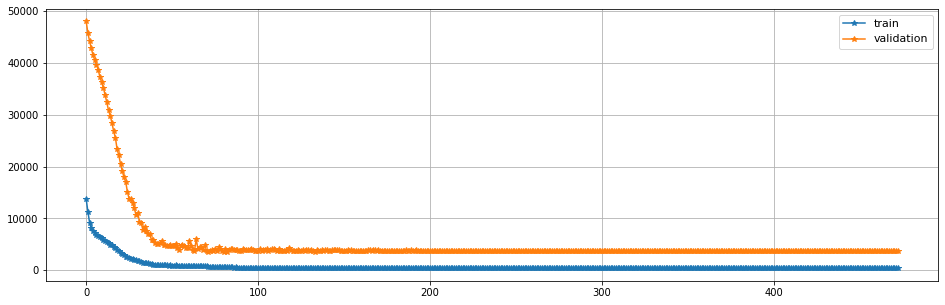

In [22]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

## Fine-tuning

In [23]:
model_path = folder + 'modelo_best.h5'
checkpoint = ModelCheckpoint(model_path, monitor="val_loss",
                             save_freq = 'epoch', save_best_only=True, mode='min') 

In [24]:
# Unfreeze the base model
base_model.trainable = True

# Very low learning rate 
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics='mae') 

history = model.fit(X_train, y_train, epochs = 100, batch_size = 16,
                    validation_data= (X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/100
77/77 [==============================] - 32s 223ms/step - loss: 1435.1766 - mae: 1435.1766 - val_loss: 2926.7812 - val_mae: 2926.7812
Epoch 2/100
77/77 [==============================] - 9s 116ms/step - loss: 1119.0956 - mae: 1119.0956 - val_loss: 3244.1841 - val_mae: 3244.1841
Epoch 3/100
77/77 [==============================] - 10s 128ms/step - loss: 768.4745 - mae: 768.4745 - val_loss: 3273.8564 - val_mae: 3273.8564
Epoch 4/100
77/77 [==============================] - 9s 121ms/step - loss: 663.2310 - mae: 663.2310 - val_loss: 3363.6394 - val_mae: 3363.6394
Epoch 5/100
77/77 [==============================] - 9s 116ms/step - loss: 819.2136 - mae: 819.2136 - val_loss: 3540.3572 - val_mae: 3540.3572
Epoch 6/100
77/77 [==============================] - 9s 115ms/step - loss: 689.1423 - mae: 689.1423 - val_loss: 3400.1157 - val_mae: 3400.1157
Epoch 7/100
77/77 [==============================] - 9s 118ms/step - loss: 641.5574 - mae: 641.5574 - val_loss: 3753.3806 - val_mae: 375

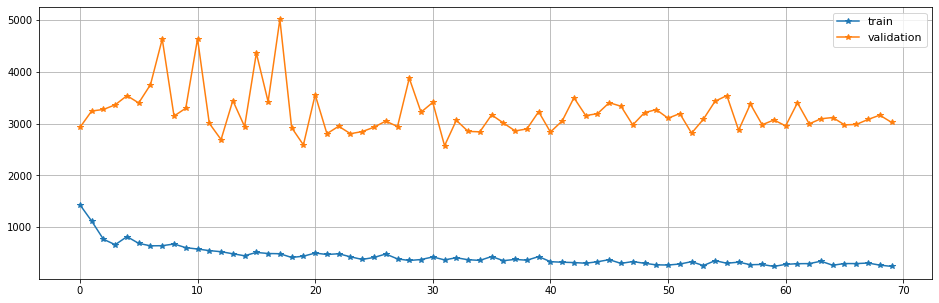

In [25]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [26]:
best_model = tf.keras.models.load_model(model_path)
best_model.evaluate(X_test, y_test)

7/7 [==============================] - 3s 50ms/step - loss: 2572.9084 - mae: 2572.9084


[2572.908447265625, 2572.908447265625]

# Images created 

In [27]:
sub_model = tf.keras.Model(inputs=best_model.input, outputs=best_model.get_layer('image_inp').output)
sub_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
layer_output = sub_model.predict(X_new, verbose=1)

45/45 [==============================] - 0s 2ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Image Input 1000')

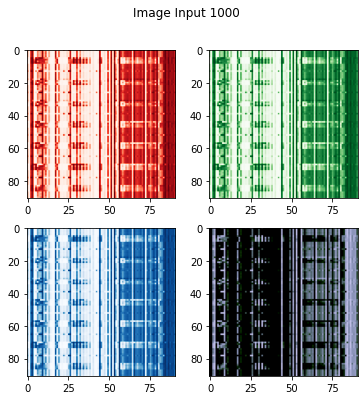

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs[0,0].imshow(layer_output[1000][:,:,0], cmap='Reds')
axs[0,1].imshow(layer_output[1000][:,:,1], cmap='Greens')
axs[1,0].imshow(layer_output[1000][:,:,1], cmap='Blues')
axs[1,1].imshow(layer_output[1000])
fig.suptitle('Image Input 1000', fontsize=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


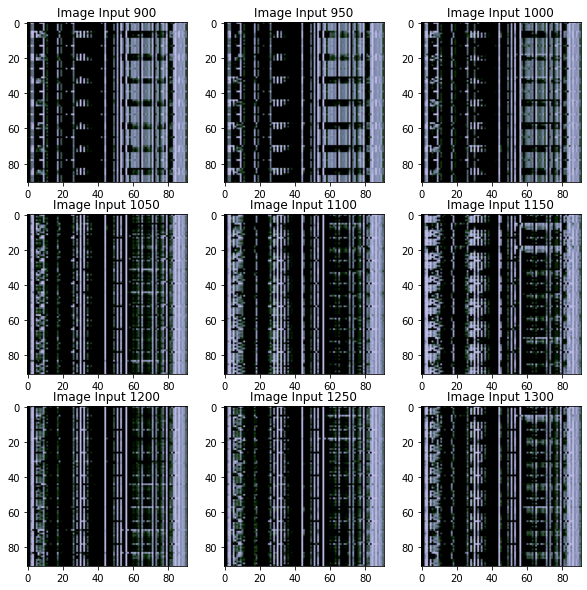

In [30]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for idx,i in enumerate(range(900,1350,50)):
  axs.flat[idx].imshow(layer_output[i])
  axs.flat[idx].set_title('Image Input ' + str(i))

# Results

In [31]:
y_pred_test = best_model.predict(X_test, verbose=1)
y_pred_redes = best_model.predict(X_new, verbose=1)

45/45 [==============================] - 2s 48ms/step


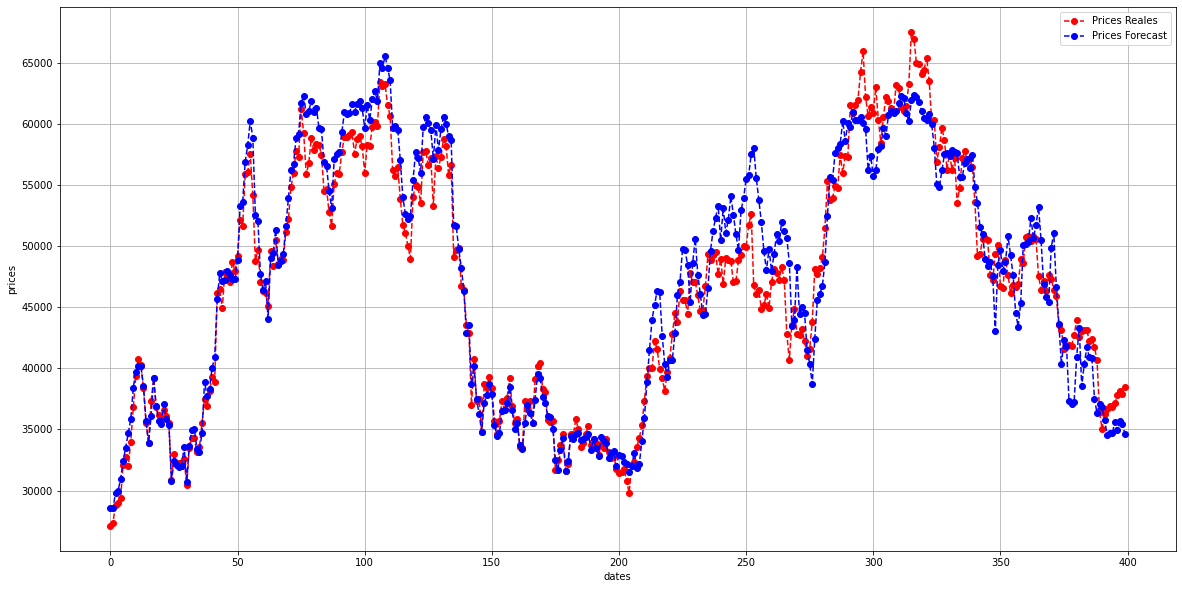

In [36]:
c = 400
day_pred = 0

fig=plt.figure(figsize=(20, 10))
plt.plot(y[-c:, day_pred], '--bo', label = 'Prices Reales', color = "r")
plt.plot(y_pred_redes[-c:, day_pred], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

In [37]:
y_test_original = y_test
y_pred_test = y_pred_test

y_original = y
y_pred_full = y_pred_redes

In [38]:
errores_test = np.empty([len(y_test)])
for i in range(0,len(y_test)):
    errores_test[i] = np.linalg.norm(y_test_original[i] - y_pred_test[i], np.inf)

errores_full = np.empty([len(y)])
for i in range(0,len(y)):
    errores_full[i] = np.linalg.norm(y_original[i] - y_pred_full[i], np.inf)

In [39]:
print("Errores Test")
print(pd.DataFrame(errores_test).describe().transpose().round(2))
print("Errores Full")
print(pd.DataFrame(errores_full).describe().transpose().round(2))

Errores Test
   count     mean      std    min      25%      50%      75%       max
0  200.0  2572.91  1937.55  54.74  1149.68  2145.31  3739.14  11277.25
Errores Full
    count    mean      std   min    25%     50%     75%       max
0  1426.0  658.96  1209.85  0.05  78.47  166.32  499.07  11277.25


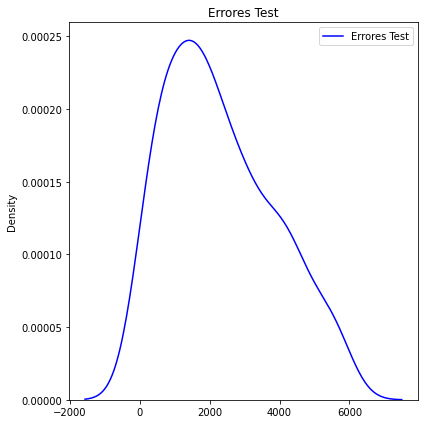

In [40]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_test[errores_test < np.percentile(errores_test, 95)], color = "blue", label = 'Errores Test')
plt.title('Errores Test')
plt.tight_layout()
plt.legend()
plt.show()

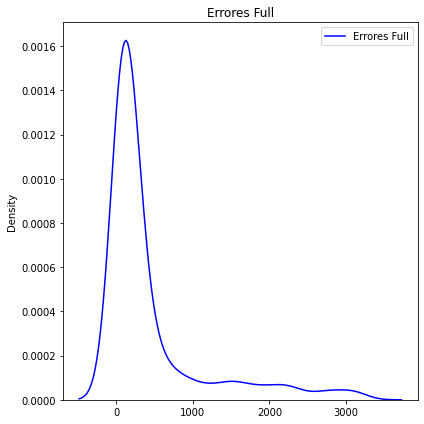

In [41]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_full[errores_full < np.percentile(errores_full, 95)], color = "blue", label = 'Errores Full')
plt.title('Errores Full')
plt.tight_layout()
plt.legend()
plt.show()

In [42]:
best_redes_test = np.argmin(errores_test)
worse_redes_test = np.argmax(errores_test)

best_redes_full = np.argmin(errores_full)
worse_redes_full = np.argmax(errores_full)

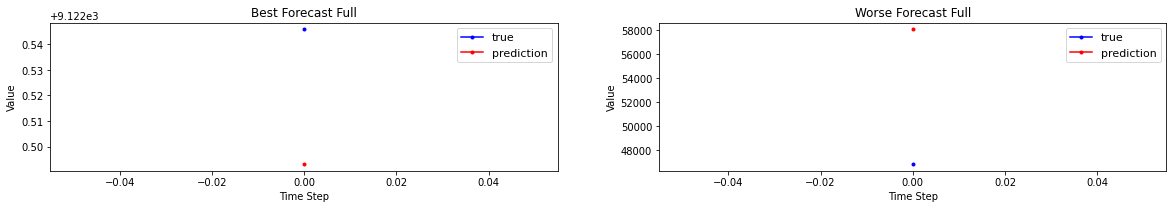

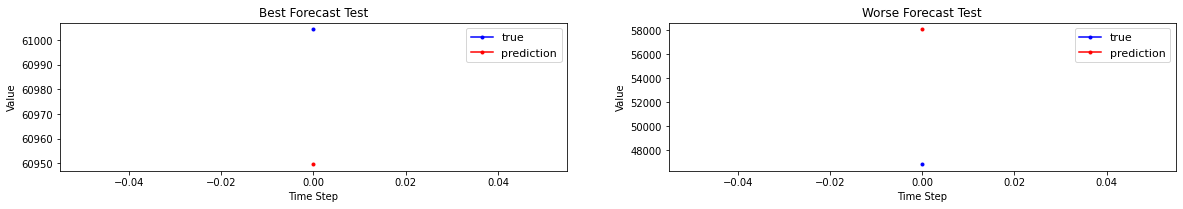

In [43]:
plt.figure(figsize=(20, 6))
plt.subplot(221)
plt.title("Best Forecast Full")
plt.plot(y_original[best_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[best_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(222)
plt.title("Worse Forecast Full")
plt.plot(y_original[worse_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[worse_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Test")
plt.plot(y_test_original[best_redes_test],  color = "blue", marker='.', label="true")
plt.plot(y_pred_test[best_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Test")
plt.plot(y_test_original[worse_redes_test], color = "blue", marker='.', label="true")
plt.plot(y_pred_test[worse_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();